In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format

### 위 꼬리가 긴 양봉이 자주 발생한다.    
위 꼬리는 종가보다 고가가 더 높이 위치해 있는 양봉입니다. 따라서 고가를 종가로 나눈 값이 1 보다 상당히 크면 위꼬리 양봉이라고 할 수 있습니다. 양봉의 조건은 종가가 시가보다 큰 것입니다. 이 것을 데이터로 표현합니다.



In [2]:
mdl_data = pd.read_pickle('mdl_data.pkl')
mdl_data.head().style.set_table_attributes('style="font-size: 12px"')

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market,close_r1,close_r2,close_r3,close_r4,close_r5,max_close
2021-01-05,2270,2285,2200,2250,410263,-0.004425,060310,3S,1.008326,0.995575,0,1.017778,1.017778,0.997778,0.966667,0.971111,1.017778
2021-01-06,2225,2310,2215,2290,570349,0.017778,060310,3S,0.995567,1.017778,1,1.000000,0.980349,0.949782,0.954148,0.949782,1.000000
2021-01-07,2290,2340,2240,2290,519777,0.000000,060310,3S,1.007612,1.000000,0,0.980349,0.949782,0.954148,0.949782,0.958515,0.980349
2021-01-08,2300,2315,2225,2245,462568,-0.019651,060310,3S,0.998918,0.980349,0,0.968820,0.973274,0.968820,0.977728,0.973274,0.977728
2021-01-11,2230,2275,2130,2175,409057,-0.031180,060310,3S,0.988702,0.968820,0,1.004598,1.000000,1.009195,1.004598,1.002299,1.009195


In [3]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_h3 = pd.DataFrame()

for code in kosdaq_list['code']:

    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    
    data['positive_candle'] = (data['close'] > data['open']).astype(int) # 양봉
    data['high/close'] = (data['positive_candle']==1)*(data['high']/data['close'] > 1.1).astype(int) # 양봉이면서 고가가 종가보다 높게 위치 10% 이상 높은 경우
    data['num_high/close'] =  data['high/close'].rolling(20).sum()
       
    data['max_close']  = data[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) # 5 영업일 종가 수익율 중 최고 값
    data.dropna(subset=['num_high/close','close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True) # missing 이 있는 행은 제거  
    
    data_h3 = pd.concat([data, data_h3], axis=0)

data_h3.to_pickle('data_h3.pkl')  

<br> 윗 꼬리가 긴 양봉이 많이 발생할 수 록 수익율에 좋은 영향을 주는 것으로 분석이 되었습니다.

                 count  mean
num_high/close              
0.000           355754 1.031
1.000            37734 1.043
2.000             5113 1.050
3.000              824 1.072
4.000              159 1.047
5.000               10 1.168


<AxesSubplot:xlabel='num_high/close'>

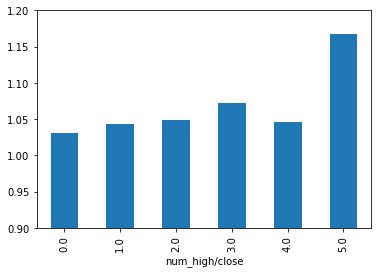

In [8]:
data_h3 = pd.read_pickle('data_h3.pkl')
print(data_h3.groupby('num_high/close')['max_close'].agg(['count','mean']))
data_h3.groupby('num_high/close')['max_close'].mean().plot(kind='bar', ylim=(0.9,1.2)) # 막대그래프로 표현

<br> 윗 꼬리가 긴 양봉도 궁금하지만, 장대양봉은 어떨지도 궁금합니다. 이렇게 가설을 검증하는 과정에서 새로운 가설을 테스트하기도 합니다. 장대양봉이 과거 60일 동안 몇 번 발생했는지 카운트해보고, 장대양봉의 갯 수와 수익율 사이에 상관성이 있는 지 함 보겠습니다.

In [9]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_h3 = pd.DataFrame()

for code in kosdaq_list['code']:

    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    
    data['positive_candle'] = (data['close'] > data['open']).astype(int) # 양봉
    data['long_candle'] = (data['positive_candle']==1)*(data['high']==data['close'])*\
    (data['low']==data['open'])*(data['close']/data['open'] > 1.2).astype(int) # 장대 양봉을 데이터로 표현
    
    data['num_long'] =  data['long_candle'].rolling(60).sum() # 지난 20 일 동안 장대양봉의 갯 수
       
    data['max_close']  = data[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) # 5 영업일 종가 수익율 중 최고 값
    data.dropna(subset=['num_long','close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True) # missing 이 있는 행은 제거  
    
    data_h3 = pd.concat([data, data_h3], axis=0)

data_h3.to_pickle('data_h3.pkl')  

<br> 과거 60일 동안 장대양봉이 2 번 발생한 경우 좋은 수익율을 보여주고 있습니다.

           count  mean
num_long              
0.000     337432 1.031
1.000       5394 1.047
2.000         88 1.056


<AxesSubplot:xlabel='num_long'>

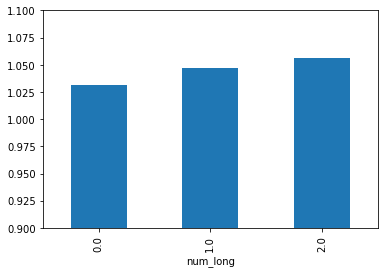

In [11]:
data_h3 = pd.read_pickle('data_h3.pkl')
print(data_h3.groupby('num_long')['max_close'].agg(['count','mean']))
data_h3.groupby('num_long')['max_close'].mean().plot(kind='bar', ylim=(0.9,1.1))